In [1]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append("../lib")

In [2]:
from benchmark import get_benchmark_folder
from benchmark import iterate_over
from benchmark import load_config_and_check

In [3]:
TEST_NAME = 'ks'
# v01 - controlled benchmark
CONFIG_V01 = load_config_and_check("../config/experiment_v01.yaml")
# v02 - unknown diverence > Qiskit vs Circ on random algos
CONFIG_V02 = load_config_and_check("../config/experiment_v02.yaml")

TEST_FOLDERS = [
    os.path.join(get_benchmark_folder(CONFIG_V01, benchmark_name, 'predictions'), TEST_NAME)
    for benchmark_name in ["across_runs_cirq", "across_runs_qiskit", "program_x_vs_program_y", "program_vs_random"]
]
TEST_FOLDERS += [
    os.path.join(get_benchmark_folder(CONFIG_V02, benchmark_name, 'predictions'), TEST_NAME)
    for benchmark_name in ["cross_platform"]
]

In [4]:
TEST_FOLDERS

['../data/experiment_v01/across_runs_cirq/predictions/ks',
 '../data/experiment_v01/across_runs_qiskit/predictions/ks',
 '../data/experiment_v01/program_x_vs_program_y/predictions/ks',
 '../data/experiment_v01/program_vs_random/predictions/ks',
 '../data/experiment_v02/cross_platform/predictions/ks']

In [5]:
from itertools import chain
records = [
    list(zip(*list(iterate_over(folder, ".json", parse_json=True))))[1]
    for folder in TEST_FOLDERS
]
all_record = []
for record_list in records:
    all_record.extend(record_list)
    

In [6]:
len(all_record)

5000

In [7]:
df_test_results = pd.DataFrame.from_records(all_record)

In [8]:
df_test_results.head()

,test,test_long_name,circuit_id,benchmark_name,random_seed,statistic,p_value
0,ks,Kolmogorov–Smirnov Test,715,across_runs_cirq,None,0.010742,0.731964
1,ks,Kolmogorov–Smirnov Test,115,across_runs_cirq,None,0.020386,0.066448
2,ks,Kolmogorov–Smirnov Test,101,across_runs_cirq,None,0.009888,0.818124
3,ks,Kolmogorov–Smirnov Test,516,across_runs_cirq,None,0.008911,0.901014
4,ks,Kolmogorov–Smirnov Test,652,across_runs_cirq,None,0.006104,0.998026


In [9]:
mark_same_distribution_same_platform = df_test_results["benchmark_name"].isin(["across_runs_cirq", "across_runs_qiskit"])

df_null_hp = df_test_results[
    mark_same_distribution_same_platform
]
df_H1_hp = df_test_results[
    ~mark_same_distribution_same_platform
]

In [10]:
import numpy as np
from scipy import stats


def compute_pvalue(statistc: float, df_null_hp: pd.DataFrame):
    statistic_under_null_hp = df_null_hp["statistic"]
    return (100 - stats.percentileofscore(statistic_under_null_hp, statistc)) / 100

compute_pvalue(0.001, df_null_hp)

1.0

In [11]:
if TEST_NAME == 'energy':
    print("Aritficially computed the p_value with the empirical distribution of statistics under the null hypothesis")
    df_test_results["p_value"] = df_test_results["statistic"].apply(
        lambda statistic_val: compute_pvalue(statistic_val, df_null_hp)
    )

df_test_results["predicted_divergence"] = df_test_results["p_value"].apply(
    lambda pval: pval < 0.05 
)

<AxesSubplot:xlabel='benchmark_name', ylabel='statistic'>

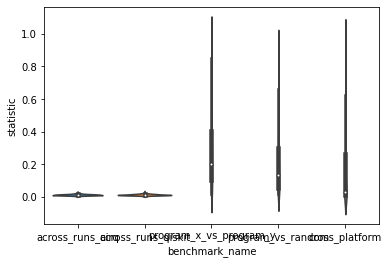

In [12]:
sns.violinplot(
    data=df_test_results,
    y='statistic',
    x='benchmark_name'
)

<AxesSubplot:xlabel='benchmark_name', ylabel='p_value'>

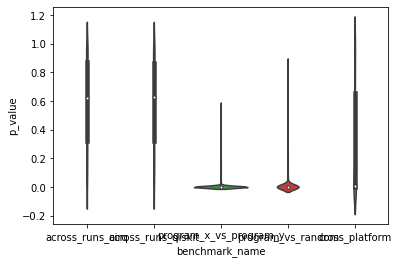

In [13]:
sns.violinplot(
    data=df_test_results,
    y='p_value',
    x='benchmark_name'
)

<AxesSubplot:xlabel='p_value', ylabel='Count'>

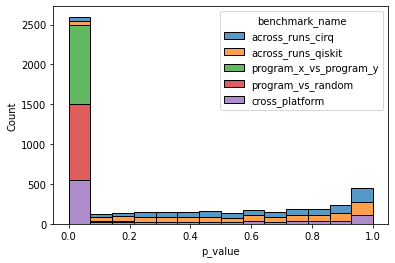

In [14]:
sns.histplot(
    data=df_test_results,
    x='p_value',
    hue='benchmark_name',
    multiple="stack"
)

In [15]:
# read the results in the energy folder and rewrite them in the energy_w_pvalue folder
# call the function: compute_energy_pvalue

# Check p_value vs n_qubits 
## (cross-platforms)

In [16]:
folder_program_info = get_benchmark_folder(CONFIG_V02, "cross_platform", "programs", "sample_a")
programs = list(zip(*iterate_over(folder_program_info, ".json", parse_json=True)))[1]
df_programs = pd.DataFrame.from_records(programs)
df_programs.head()

,n_qubits,n_ops,gate_set,strategy_program_generation,circuit_id,benchmark_name
0,18,85,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,715,cross_platform
1,15,135,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,115,cross_platform
2,9,31,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,101,cross_platform
3,20,128,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,516,cross_platform
4,5,46,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,652,cross_platform


In [17]:
df_cross_w_program_info = pd.merge(df_programs, df_test_results, on=['circuit_id', 'benchmark_name'])
df_cross_w_program_info.head()

,n_qubits,n_ops,gate_set,strategy_program_generation,circuit_id,benchmark_name,test,test_long_name,random_seed,statistic,p_value,predicted_divergence
0,18,85,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,715,cross_platform,ks,Kolmogorov–Smirnov Test,None,0.606934,0.000000e+00,True
1,15,135,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,115,cross_platform,ks,Kolmogorov–Smirnov Test,None,0.110229,9.710561e-44,True
2,9,31,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,101,cross_platform,ks,Kolmogorov–Smirnov Test,None,0.010132,7.944616e-01,False
3,20,128,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,516,cross_platform,ks,Kolmogorov–Smirnov Test,None,0.156006,2.312146e-87,True
4,5,46,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,652,cross_platform,ks,Kolmogorov–Smirnov Test,None,0.007935,9.587457e-01,False


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   p_value    1000 non-null   float64
 1   n_qubits   1000 non-null   int64  
 2   n_ops      1000 non-null   int64  
 3   statistic  1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 39.1 KB


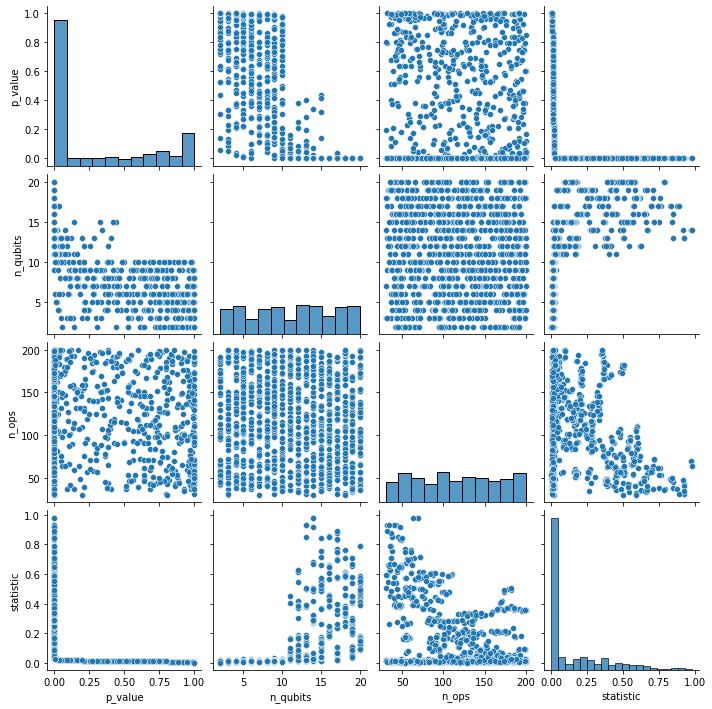

In [18]:
tmp_data = df_cross_w_program_info[['p_value', 'n_qubits', 'n_ops', 'statistic']]
tmp_data.info()
sns.pairplot(tmp_data)

## (across_platform = truly the same)

In [19]:
folder_program_info = get_benchmark_folder(CONFIG_V01, "across_runs_qiskit", "programs", "sample_a")
programs = list(zip(*iterate_over(folder_program_info, ".json", parse_json=True)))[1]
df_programs = pd.DataFrame.from_records(programs)
df_programs.head()

,n_qubits,n_ops,gate_set,strategy_program_generation,circuit_id,benchmark_name
0,18,85,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,715,across_runs_qiskit
1,15,135,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,115,across_runs_qiskit
2,9,31,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,101,across_runs_qiskit
3,20,128,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,516,across_runs_qiskit
4,5,46,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,652,across_runs_qiskit


In [20]:
df_across_w_program_info = pd.merge(df_programs, df_test_results, on=['circuit_id', 'benchmark_name'])
df_across_w_program_info.head()

,n_qubits,n_ops,gate_set,strategy_program_generation,circuit_id,benchmark_name,test,test_long_name,random_seed,statistic,p_value,predicted_divergence
0,18,85,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,715,across_runs_qiskit,ks,Kolmogorov–Smirnov Test,None,0.018921,0.106486,False
1,15,135,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,115,across_runs_qiskit,ks,Kolmogorov–Smirnov Test,None,0.011597,0.640362,False
2,9,31,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,101,across_runs_qiskit,ks,Kolmogorov–Smirnov Test,None,0.008789,0.909743,False
3,20,128,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,516,across_runs_qiskit,ks,Kolmogorov–Smirnov Test,None,0.012329,0.562065,False
4,5,46,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,652,across_runs_qiskit,ks,Kolmogorov–Smirnov Test,None,0.005005,0.999953,False


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   p_value    1000 non-null   float64
 1   n_qubits   1000 non-null   int64  
 2   n_ops      1000 non-null   int64  
 3   statistic  1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 39.1 KB


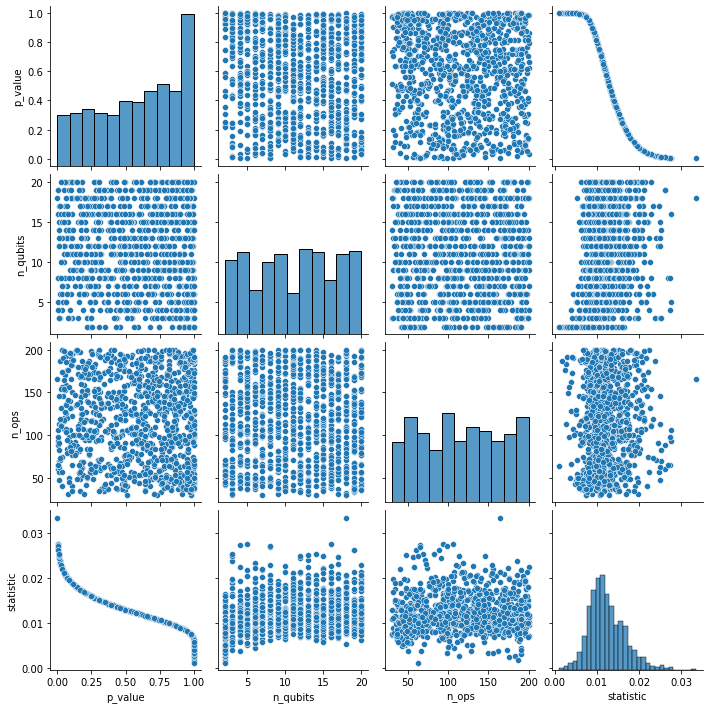

In [21]:
tmp_data = df_across_w_program_info[['p_value', 'n_qubits', 'n_ops', 'statistic']]
tmp_data.info()
sns.pairplot(tmp_data)

## (program_vs_random = truly divergent)

In [22]:
folder_program_info = get_benchmark_folder(CONFIG_V01, "program_vs_random", "programs", "sample_a")
programs = list(zip(*iterate_over(folder_program_info, ".json", parse_json=True)))[1]
df_programs = pd.DataFrame.from_records(programs)
df_vs_random_w_program_info = pd.merge(df_programs, df_test_results, on=['circuit_id', 'benchmark_name'])
df_vs_random_w_program_info.head()

,n_qubits,n_ops,gate_set,strategy_program_generation,circuit_id,benchmark_name,test,test_long_name,random_seed,statistic,p_value,predicted_divergence
0,18,85,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,715,program_vs_random,ks,Kolmogorov–Smirnov Test,None,0.612427,0.000000e+00,True
1,15,135,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,115,program_vs_random,ks,Kolmogorov–Smirnov Test,None,0.091797,1.908661e-30,True
2,9,31,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,101,program_vs_random,ks,Kolmogorov–Smirnov Test,None,0.519531,0.000000e+00,True
3,20,128,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,516,program_vs_random,ks,Kolmogorov–Smirnov Test,None,0.113037,5.596123e-46,True
4,5,46,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",WeightedRandomCircuitGenerator,652,program_vs_random,ks,Kolmogorov–Smirnov Test,None,0.310669,9.881313e-324,True


In [ ]:
tmp_data = df_vs_random_w_program_info[['p_value', 'n_qubits', 'n_ops', 'statistic']]
tmp_data.info()
sns.pairplot(tmp_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   p_value    1000 non-null   float64
 1   n_qubits   1000 non-null   int64  
 2   n_ops      1000 non-null   int64  
 3   statistic  1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 39.1 KB
